## ExperiWatt - Gehirn und Energie
In diesem Arbeitsblatt lernt ihr eigenständig eine vollständige Bearbeitung, Visualisierung und Analyse von euren eigenen EEG Daten durchzuführen. Dafür benötigen wir einige Funktionen des Python Softwarepackages MNE. In dem Dokument **"MNE Funktionen"** findet ihr eine Liste an Funktionen die ihr dafür braucht.


Jede grau hinterlegte Notebook "Box" entält **Kommentare** (gekennzeichnet durch das #-Symbol), die euch Hinweise dazu geben, welche Funktion ihr für die jeweilige Aufgabe verwenden müsst.

In [2]:
# zunächst importieren wir das MNE Package, damit wir es verwenden können
import mne 
from mne import viz
from mne.io import RawArray
from mne.preprocessing import ICA
from mne_icalabel import label_components
from pyprep.find_noisy_channels import find_bad_by_ransac
import matplotlib.pyplot as plt
import numpy as np
from meegkit.detrend import detrend
from meegkit.dss import dss_line
import pandas as pd

2024-02-12 13:57:29,295 - numexpr.utils - INFO - Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2024-02-12 13:57:29,297 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.


In [3]:
# Hilfreiche Funktionen
def plot_signal(raw, start=0, end=None, sfreq=500, electrodes=range(24)):
    start = start*sfreq
    if not end:
        end = raw.get_data().shape[1]
    else: 
        end = end*sfreq
        
    plt.plot(raw.times[start:end], raw.get_data()[electrodes, start:end].T*1e6, linewidth=0.4)
    plt.xlabel('Time [s]')
    plt.ylabel('Voltage [muV]')
    plt.title('Activity')
    plt.show()

def threshold_electrode(raw, threshold):
    '''
    threshold: value in µV
    '''

    # load electrode names 
    electrode_info = pd.read_csv('electrode_info.csv')
    electrode_names = electrode_info['electrodes'][0:24]
    
    # Find the electrode(s) over threshold
    electrodes_above_threshold = np.any(raw.get_data() > threshold*1e-6, axis=1)
    
    # Print the index(es) of the electrode(s)
    electrode_indices = np.where(electrodes_above_threshold)[0]
    print(f"Electrode(s) with values above {threshold}: Name {np.array(electrode_names[electrode_indices])}")
    
def detrend_baselines(raw):
    X = raw.get_data().T # transpose so the data is organized time-by-channels
    X, _, _ = detrend(X, order=1)
    X, _, _ = detrend(X, order=6)
    raw._data = X.T  # overwrite raw data
    raw.set_eeg_reference('average', projection=True)  #compute the reference

def detect_bad_channels(raw, corr_thresh=0.75):
    bads, _ = find_bad_by_ransac(
         data = raw.get_data(),
         sample_rate = raw.info['sfreq'],
         complete_chn_labs = np.asarray(raw.info['ch_names']),
         chn_pos = np.stack([ch['loc'][0:3] for ch in raw.info['chs']]),
         exclude = [],
         corr_thresh = corr_thresh
         )

    raw.info['bads'] = bads
    raw.interpolate_bads()
    raw.set_eeg_reference('average', projection=True)  #compute the reference
    raw.apply_proj()
    
    return bads

### EEG Daten laden
Um unsere Daten einsehen zu können müssen wir sie in unser Notebook laden. Danach können wir bereits einen ersten Blick auf die Daten werfen! Denke an sinnvolle Variable benennung.

**2 Punkte**

In [49]:
mne.datasets.somato.data_path()

Using default location ~/mne_data for somato...


100%|########################################| 611M/611M [00:00<00:00, 609GB/s]
Untarring contents of 'C:\Users\gross\mne_data\MNE-somato-data.tar.gz' to 'C:\Users\gross\mne_data'


Download complete in 02m45s (582.2 MB)


WindowsPath('C:/Users/gross/mne_data/MNE-somato-data')

In [50]:
# Name der Datei
fdir = 'Experiment/output_data/'
fname_passive = 'sub-6_ses-sleepy.fif'
fname_active = 'sub-6_ses-power.fif'

# Lade die Datei. In MNE werden EEG Datensätze im "Raw" format gespeichert.
raw_passive = mne.io.read_raw_fif(fdir+fname_passive, preload=True)
raw_active = mne.io.read_raw_fif(fdir+fname_active, preload=True)

# Lösche die ersten 10 sekunden, da die Teilnehmer in der Zeit ihren Blick auf das Fixierungs-Kreuz gerichtet haben
start_time = 10
raw_passive.crop(tmin=start_time)
raw_active.crop(tmin=start_time)
#raw_passive._data = raw_passive.get_data()[:, int(start_time*raw_passive.info['sfreq']):]
#raw_active._data = raw_active.get_data()[:, int(start_time*raw_active.info['sfreq']):]

Opening raw data file Experiment/output_data/sub-6_ses-sleepy.fif...
Isotrak not found
    Range : 0 ... 14868 =      0.000 ...    29.736 secs
Ready.
Reading 0 ... 14868  =      0.000 ...    29.736 secs...
Opening raw data file Experiment/output_data/sub-6_ses-power.fif...
Isotrak not found
    Range : 0 ... 14872 =      0.000 ...    29.744 secs
Ready.
Reading 0 ... 14872  =      0.000 ...    29.744 secs...


C:\Users\gross\AppData\Local\Temp\ipykernel_36068\2373913846.py:7: RuntimeWarning: This filename (Experiment/output_data/sub-6_ses-sleepy.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_passive = mne.io.read_raw_fif(fdir+fname_passive, preload=True)
C:\Users\gross\AppData\Local\Temp\ipykernel_36068\2373913846.py:8: RuntimeWarning: This filename (Experiment/output_data/sub-6_ses-power.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_active = mne.io.read_raw_fif(fdir+fname_active, preload=True)


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,Not available
Good channels,24 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,500.00 Hz
Highpass,0.00 Hz
Lowpass,250.00 Hz


Das Raw Format ist praktisch, da es viele Informationen über die Daten enthält, so wie die Sampling Rate (gemessene Datenpunkte pro Sekunde) und die Anzahl an Kanälen.

In [ ]:
# Sieh dir alle Infos zu dem Datensatz an
raw_active.info

Das EEG Signal ist jetzt noch nicht gefiltert und von Artefakten befreit worden, weshalb das Signal chaotisch aussieht.. Das werden wir in dem Abschnitt **Preprocessing** beheben.

### Elektroden Mapping
Das Softwarepackage MNE ermöglicht es uns mit einer standardisierten Map die EEG Aktivität auf die Kanäle die der Position auf dem Kopf entsprechen zu projezieren. Die folgende Abbildung zeigt wie die Montur für das EEG System aussehen sollte.

<div>
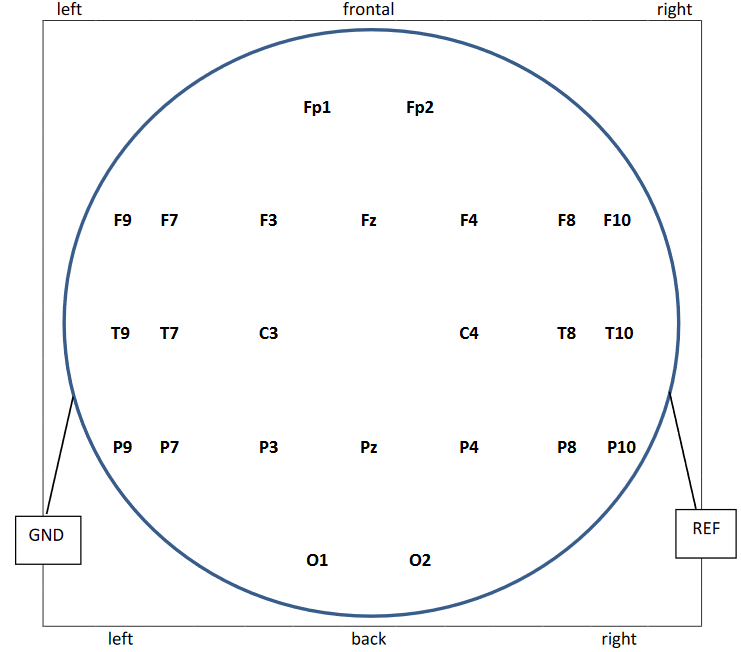
</div>

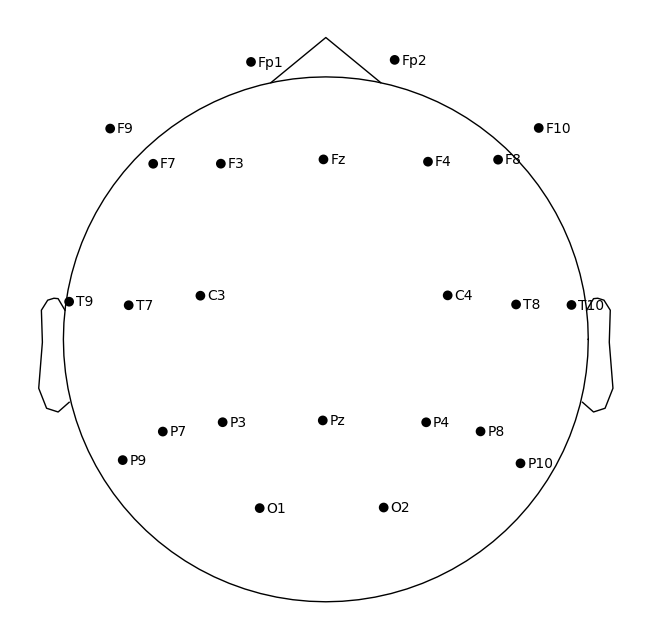

In [51]:
# Standard Map laden und an Datensatz zufügen
montage = mne.channels.make_standard_montage('standard_1020')
raw_active.set_montage(montage)
raw_passive.set_montage(montage)

# Erstelle ein Plot der Standard Montage und vergleiche sie mit der obigen Abbildung. 
fig = raw_active.plot_sensors(show_names=True)

### Daten Betrachtung

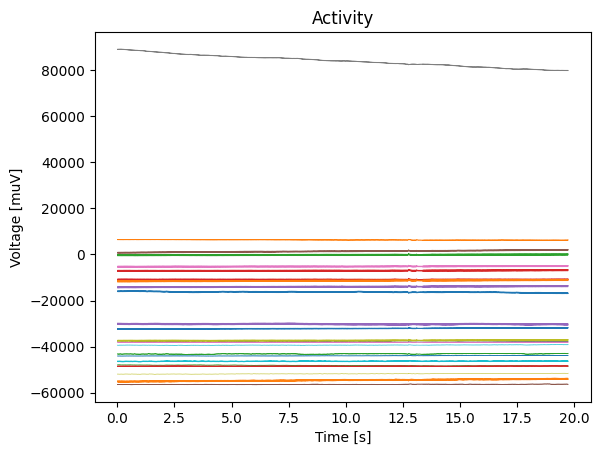

In [56]:
# Erstelle einen Plot der EEG Daten von 5 Kanälen über 5 Sekunden. 
# Starte von Sekunde 10. Verwende außerdem lowpass=40 und highpass=70.
# Verwende dazu die mne function "plot()"
plt.ion()
#raw_passive.plot(duration=5, start=10, n_channels=5, lowpass=40, highpass=70)
plot_signal(raw_active, electrodes=range(24))

# Verwende diese Zeile "plt.show()" nach jeder Grakfik die du erstellst. Ansonsten wird die Grafik immer doppelt gezeigt.
plt.show()

Falls ihr eine Elektrode (oder mehrere) entdeckt die viel höhere Werte hat als alle anderen, solltet ihr herausfinden welche es ist...

In [57]:
# Dazu könnte ihr die Funktion "threshold_electrode()" verwenden
# Sie gibt an welche Elektrode über einen bestimmten Wert gestiegen ist 
threshold_electrode(raw_active, 60000)

Electrode(s) with values above 60000: Name ['P7']


In [58]:
# Entferne Kanäle die keine Aktivität zeigen 
raw_passive.info['bads'] = ['P7']
raw_passive.interpolate_bads()
raw_passive.set_eeg_reference('average', projection=True)  #compute the reference
raw_passive.apply_proj()

# Entferne Kanäle die keine Aktivität zeigen 
raw_active.info['bads'] = ['P7']
raw_active.interpolate_bads()
raw_active.set_eeg_reference('average', projection=True)  #compute the reference
raw_active.apply_proj()

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 96.8 mm
Computing interpolation matrix from 23 sensor positions
Interpolating 1 sensors
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 96.8 mm
Computing interpolation matrix from 23 sensor positions
Interpolating 1 sensors
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an S

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,27 points
Good channels,24 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,500.00 Hz
Highpass,0.00 Hz
Lowpass,250.00 Hz


### Power Spectrum
EEG Daten sind aus Signalen von verschiedenen Frequenzen zusammengesetzt. Wenn ihr in der obigen `plot()` Funktion mit den Werten für `lowpass` und `highpass` spielt, seht ihr, dass es einen großen Einfluss auf das Signal hat. "low"- und "highpass" sind Filter, die bestimmte Frequenzen aus dem Signal entfernen. Dies ist sehr praktisch, da nicht alle Frequenzen echte Gehirnaktivität darstellen. Mehr über Filter lernt ihr im nächsten Abschnitt **Preprocessing**

Jede Frequenz trägt unterschiedlich viel zur gesamten Leistung des Signals bei. In diesem Aufgabenteil wollen herausfinden welche Frequenzen in unseren EEG Daten am stärksten vertreten sind. 

In der folgenden Abbildung seht ihr wie ein typisches EEG Spektrum ausseht. Vergleicht euer Spektrum mit diesem (achtet auf die x-Achse) und beschreibt was ihr seht.
<div>
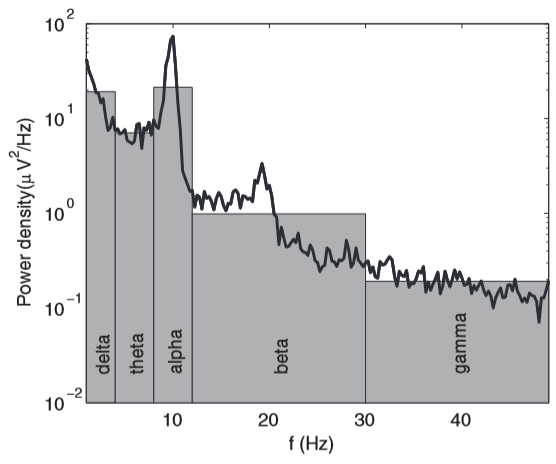
</div>


Effective window size : 4.096 (s)


C:\Users\gross\AppData\Roaming\Python\Python39\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


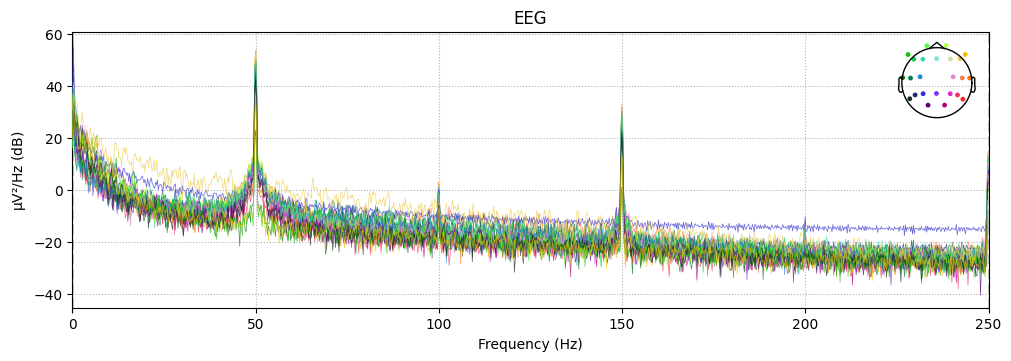

In [59]:
# um einen solchen plot zu erstellen verwende die function "plot_psd()"
# verwende für den Parameter fmax=100  
raw_active.compute_psd().plot()
plt.show()

### Preprocessing
Die mit der EEG Kappe gemessene Aktivität ist leider nicht reine Gehirnaktivität. Da die Elektroden in der Kappe sehr sensitiv sind nehmen sie auch jede andere Veränderung von elektrischem Potenzial wahr. 
Wir werden die folgenden Rauschfaktoren Schritt für Schritt aus dem Signal entfernen:

1) Kanäle mit schlechtem Signal

2) Augenblinzeln, Herzschlag und andere Muskelstörfaktoren

3) Stromleitungen

In [60]:
# Führt erst ein Downsampling der Datendurch, so reduziert ihr die Datenpunkte - dann geht das Bearbeiten schneller!
resample_freq = 200
raw_active.resample(resample_freq)
raw_passive.resample(resample_freq)

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,27 points
Good channels,24 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,200.00 Hz
Highpass,0.00 Hz
Lowpass,100.00 Hz


#### 1) Kanäle mit unzreichendem Signal entfernen

Es ist möglich, dass einige Elektroden/Kanäle die Gehirnaktivität nicht richtig messen konnten und unbrauchbar sind - bei Trockenelektroden ist es normal, dass dies circa 20% der Kanäle sind. Wir müssen herausfinden welche Kanäle btroffen sind, um sie aus unserem Datenset zu entfernen. Dafür könnt ihr die Funktion `detect_bad_channels()` verwenden. 

In [61]:
# Prüfe ob das MNE Package beim Laden schon automatisch schlechte Kanäle gefunden hat.
raw_active.info['bads'] 

[]

In [63]:
bads_passive = detect_bad_channels(raw_passive, corr_thresh=0.9)
print(bads_passive)
bads_active = detect_bad_channels(raw_active, corr_thresh=0.9)
print(bads_active)

Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/3 [00:00<?,       ?it/s]


RANSAC done!
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 96.8 mm
Computing interpolation matrix from 16 sensor positions
Interpolating 8 sensors
EEG channel type selected for re-referencing
Projections have already been applied. Setting proj attribute to True.
['Fp1', 'F9', 'F7', 'Fz', 'T7', 'Pz', 'P10', 'O1']
Executing RANSAC
This may take a while, so be patient...


C:\Users\gross\AppData\Local\Temp\ipykernel_36068\1680823866.py:50: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True)  #compute the reference


  0%|          |  : 0/3 [00:00<?,       ?it/s]


RANSAC done!
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 96.8 mm
Computing interpolation matrix from 21 sensor positions
Interpolating 3 sensors
EEG channel type selected for re-referencing
Projections have already been applied. Setting proj attribute to True.
['F9', 'F7', 'F10']


C:\Users\gross\AppData\Local\Temp\ipykernel_36068\1680823866.py:50: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True)  #compute the reference


#### 2) Baseline Correction
Manche Kanäle\Elektroden weisen durch Bewegung oder Zustand der Kopfhaut (e.g. durch Schwitzen) flukturierende Hintergrundaktivität auf und müssen entfernt werden. Verwende hierzu die Funktion `detrend_baselines()`

In [65]:
# Verwende die Funktion "detrend_baselines()" um die Aktivität um die Baseline um die 0 mV zu bringen
detrend_baselines(raw_passive)
detrend_baselines(raw_active)

EEG channel type selected for re-referencing
EEG channel type selected for re-referencing


C:\Users\gross\AppData\Local\Temp\ipykernel_36068\1680823866.py:36: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True)  #compute the reference
C:\Users\gross\AppData\Local\Temp\ipykernel_36068\1680823866.py:36: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True)  #compute the reference


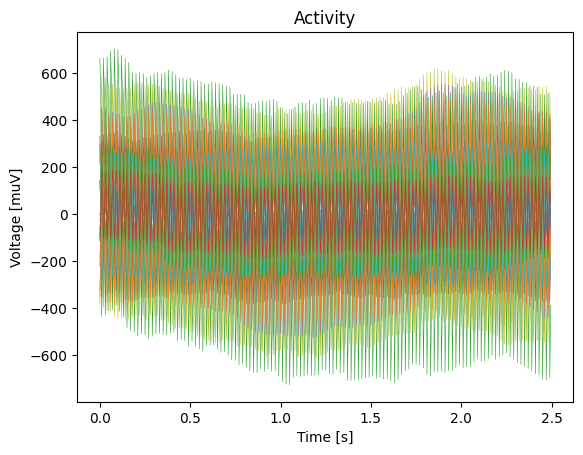

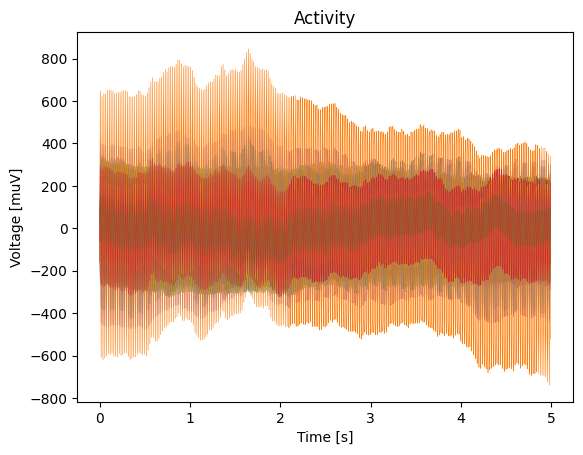

In [66]:
# Schaue dir an wie die Daten vorher aussehen
plot_signal(raw_passive, start=0, end=1, electrodes=range(24))
plt.show()
plot_signal(raw_active, start=0, end=2, electrodes=range(24))
plt.show()

#### 3) Störungen durch Stromleitungen
Beim Betrachten des Power Density Spectrums ist euch sicher ein starke Spitze um 50Hz aufgefallen. Das sind die Wechselstromleitungen die von den EEG Elektroden aufgezeichnet werden. Damit wir dieses Signal loswerden können und dabei möglichst wenig der gemessenen Gehirnaktivität löschen, verwenden wir den sogenannten ZapLine Algorithmus. Dieser wurde in der Funktion `dss_line()` implementiert. Achtet darauf die richtige Frequenz der Stromleitung einzugeben. Passe außerdem den Parameter 'nremove' an, jenach Stärke des Störsignals. Je höher der Wert desto stärker die Filter-Wirkung

In [67]:
# Verwende "dss_line()" für das "passive" Datenset ...
X_zapline_passive, noise = dss_line(raw_passive.get_data().T, fline=50, sfreq=raw_passive.info['sfreq'], nremove=11)
raw_passive_zapline = RawArray(X_zapline_passive.T, raw_passive.info)

# ... und für das "aktive"
X_zapline_active, noise = dss_line(raw_active.get_data().T, fline=50, sfreq=raw_active.info['sfreq'], nremove=11)
raw_active_zapline = RawArray(X_zapline_active.T, raw_active.info)

Power of components removed by DSS: 0.96
Creating RawArray with float64 data, n_channels=24, n_times=3948
    Range : 0 ... 3947 =      0.000 ...    19.735 secs
Ready.
Power of components removed by DSS: 0.95
Creating RawArray with float64 data, n_channels=24, n_times=3949
    Range : 0 ... 3948 =      0.000 ...    19.740 secs
Ready.


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 10.240 (s)


C:\Users\gross\AppData\Roaming\Python\Python39\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


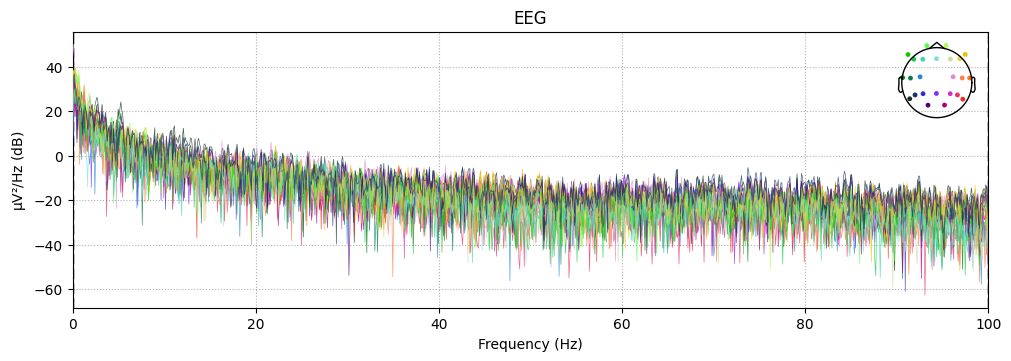

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 10.240 (s)


C:\Users\gross\AppData\Roaming\Python\Python39\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


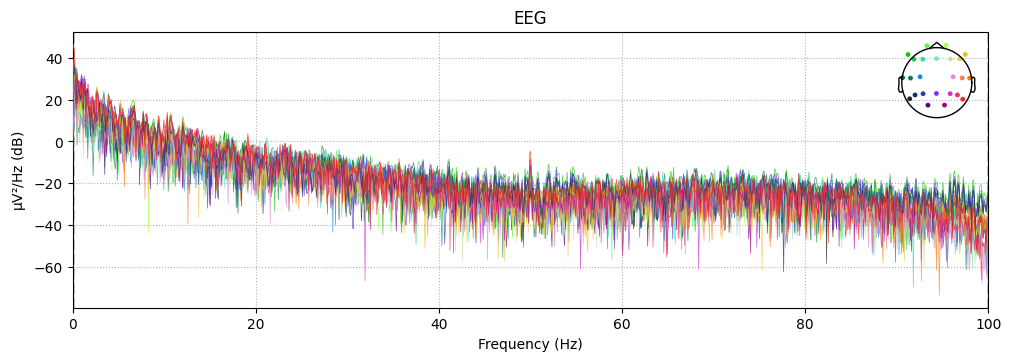

In [68]:
# Kontrolliere das Ergebnis indem du das "neue" Power Spectrum plottest. Falls du noch einen Peak bei 50Hz siest, 
# erhöhe den Wert für "nremove" in der "dss_line()" Funktion
raw_passive_zapline.plot_psd(0,100)
plt.show()

raw_active_zapline.plot_psd(0, 100)
plt.show()

In [69]:
# Filtere außerdem die 0.5Hz Leitung aus dem Signal
raw_passive_filtered = raw_passive_zapline.copy()
raw_passive_filtered.filter(l_freq=1, h_freq=None)
raw_active_filtered = raw_active_zapline.copy()
raw_active_filtered.filter(l_freq=1, h_freq=None)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 661 samples (3.305 s)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 661 samples (3.305 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,27 points
Good channels,24 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,200.00 Hz
Highpass,1.00 Hz
Lowpass,100.00 Hz


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 10.240 (s)


C:\Users\gross\AppData\Roaming\Python\Python39\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


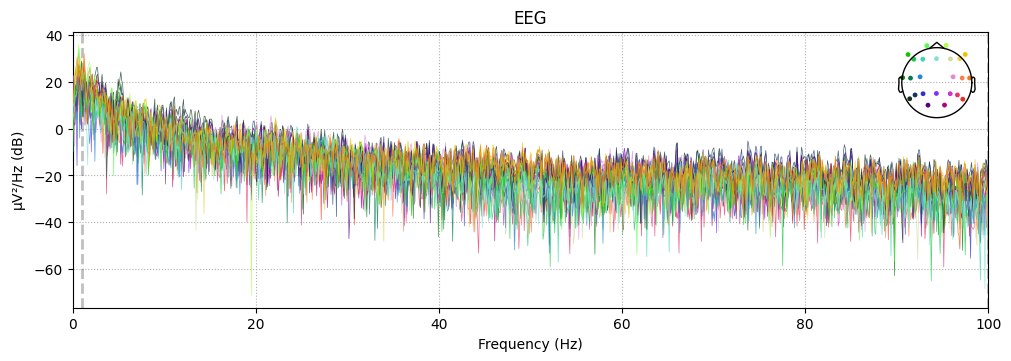

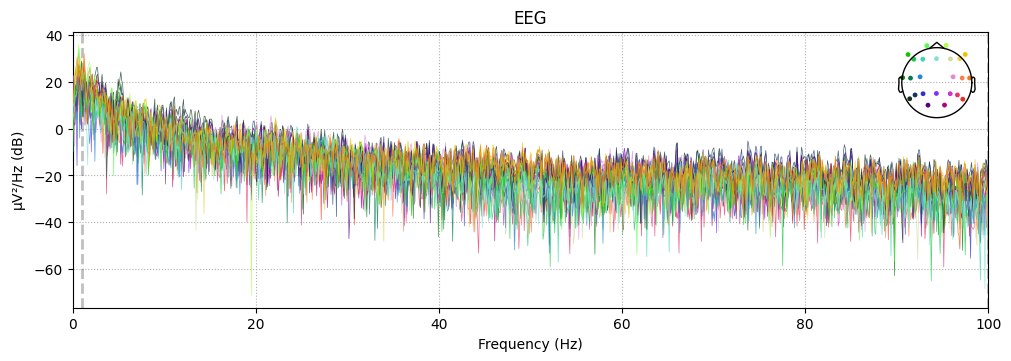

In [70]:
raw_passive_filtered.plot_psd()

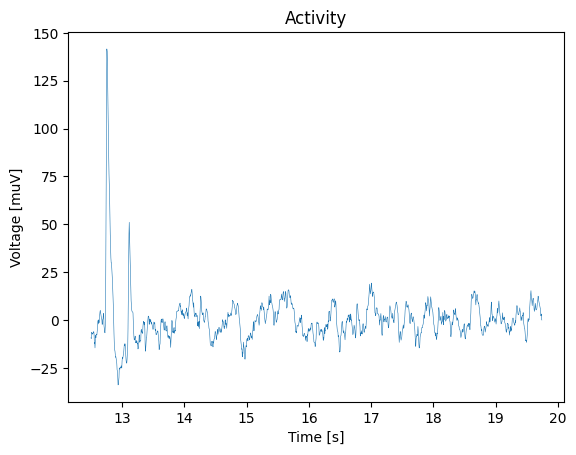

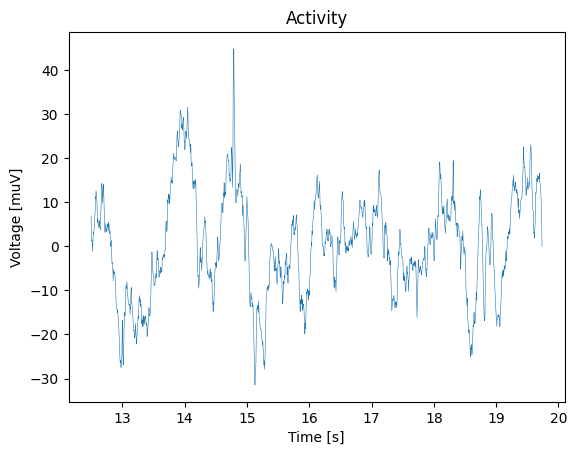

In [71]:
plot_signal(raw_active_filtered, start=5, end=20, electrodes=[10])
plot_signal(raw_passive_filtered, start=5, end=20, electrodes=[10])

#### 4) Augenblinzeln, Herzschlag und andere Muskelstörfaktoren
In diesem Abschnitt werden wir Störfaktoren wie Augenblinzeln und den Herzschlag aufspüren, wofür wir die sogenannte Independent Component Analysis (ICA) verwenden werden. Diese Analysemethode macht es möglich individuelle Störfaktoren aufzuspüren, die auf verschiedene Kanäle verteil sein können.

In [72]:
# Verwende ICA - passive
ica_passive = ICA(n_components=10, max_iter="auto", random_state=97)
ica_passive.fit(raw_passive_filtered)

# active
ica_active = ICA(n_components=10, max_iter="auto", random_state=97)
ica_active.fit(raw_active_filtered)

Fitting ICA to data using 24 channels (please be patient, this may take a while)
    Applying projection operator with 1 vector (pre-whitener computation)
    Applying projection operator with 1 vector (pre-whitener application)
Selecting by number: 10 components
    Applying projection operator with 1 vector (pre-whitener application)
Fitting ICA took 1.5s.
Fitting ICA to data using 24 channels (please be patient, this may take a while)
    Applying projection operator with 1 vector (pre-whitener computation)
    Applying projection operator with 1 vector (pre-whitener application)
Selecting by number: 10 components
    Applying projection operator with 1 vector (pre-whitener application)
Fitting ICA took 0.1s.


C:\Users\gross\anaconda3\envs\eegort\lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=1000
Fit,20 iterations on raw data (3949 samples)
ICA components,10
Available PCA components,24
Channel types,eeg
ICA components marked for exclusion,—


In [73]:
explained_var_ratio = ica_passive.get_explained_variance_ratio(
    raw_passive_filtered, components=[3], ch_type="eeg"
)
# This time, print as percentage.
ratio_percent = round(100 * explained_var_ratio["eeg"])
print(
    f"Fraction of variance in EEG signal explained by first component: "
    f"{ratio_percent}%"
)

Fraction of variance in EEG signal explained by first component: 8%


    Applying projection operator with 1 vector (pre-whitener application)
Creating RawArray with float64 data, n_channels=10, n_times=3949
    Range : 0 ... 3948 =      0.000 ...    19.740 secs
Ready.


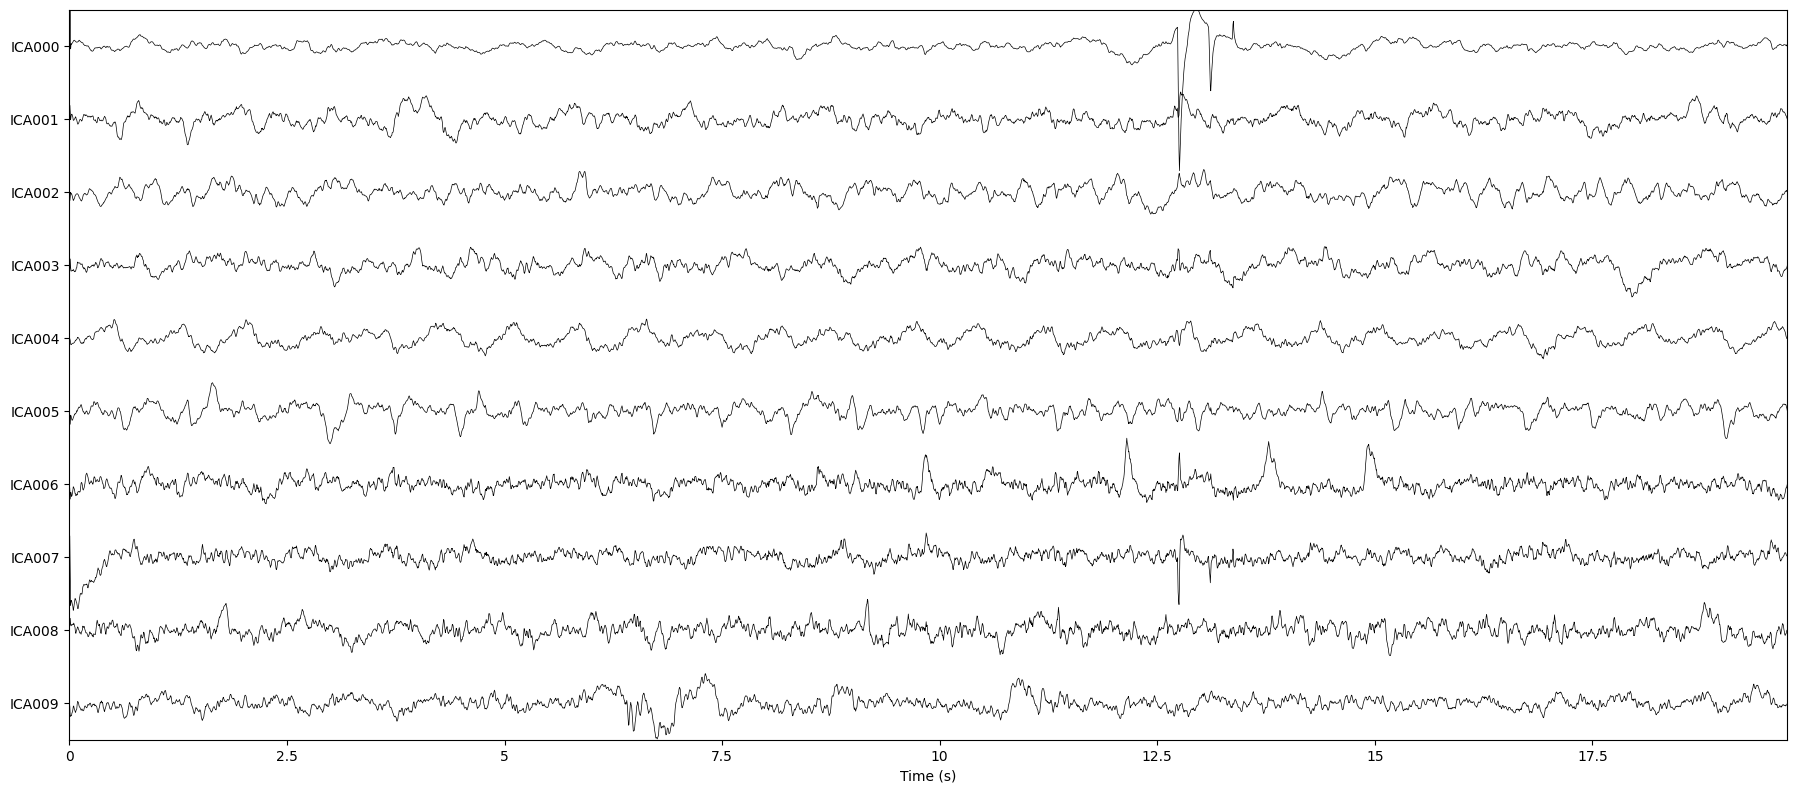

In [74]:
ica_active.plot_sources(raw_active_filtered, show_scrollbars=False)
plt.show()

    Applying projection operator with 1 vector (pre-whitener application)
Creating RawArray with float64 data, n_channels=10, n_times=3948
    Range : 0 ... 3947 =      0.000 ...    19.735 secs
Ready.


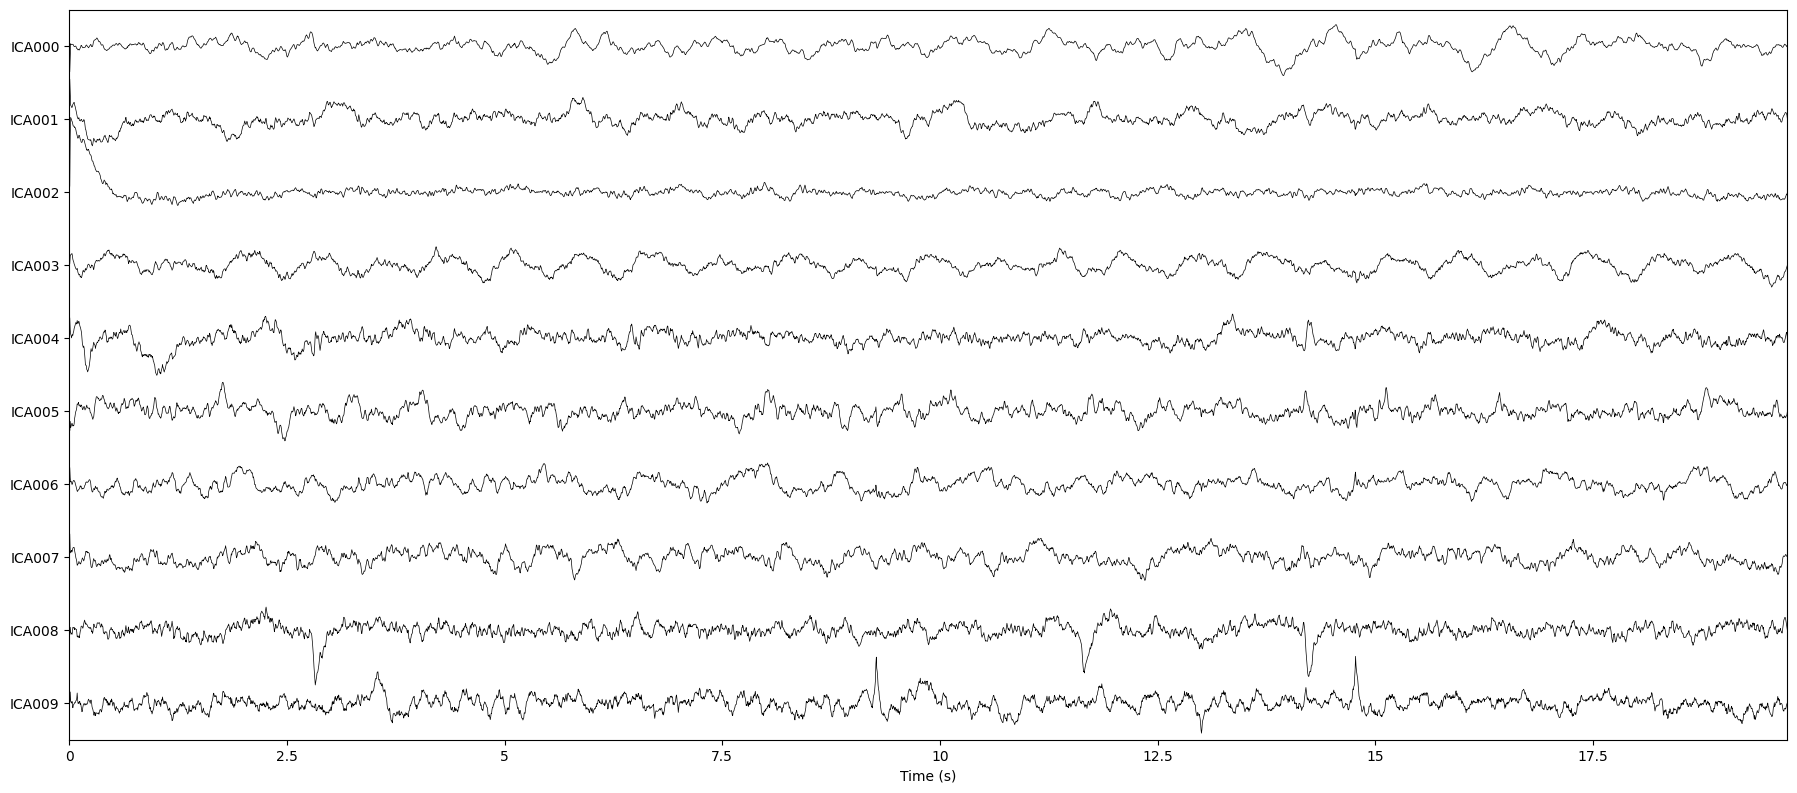

In [75]:
ica_passive.plot_sources(raw_passive_filtered, show_scrollbars=False)
plt.show()

Findet heraus was für ein Signal hinter den Komponenten steckt - Gehirnaktivität, Augenzwinkern, Herzschlag, oder Rauschen. Verwendet dafür die Funktion `label_components()`

In [76]:
ic_labels_passive = label_components(raw_passive_filtered, ica_passive, method="iclabel")
ic_labels_active = label_components(raw_active_filtered, ica_active, method="iclabel")

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\gross\anaconda3\envs\eegort\lib\site-packages\mne_icalabel\iclabel\features.py:59: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  warn(
C:\Users\gross\anaconda3\envs\eegort\lib\site-packages\mne_icalabel\iclabel\features.py:80: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit_params=dict(extended=True))' (scikit-learn) or 'ICA(method='picard', fit_params=dict(ortho=False, extended=True))' (python-picard).
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\gross\anaconda3\envs\eegort\lib\site-packages\mne_icalabel\iclabel\features.py:59: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  warn(
C:\Users\gross\anaconda3\envs\eegort\lib\site-packages\mne_icalabel\iclabel\features.py:80: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit_params=dict(extended=True))' (scikit-learn) or 'ICA(method='picard', fit_params=dict(ortho=False, extended=True))' (python-picard).
  warn(


In [77]:
print(ic_labels_passive["labels"])
print(ic_labels_active["labels"])

['other', 'other', 'brain', 'other', 'eye blink', 'brain', 'other', 'brain', 'brain', 'other']
['brain', 'brain', 'other', 'brain', 'brain', 'other', 'other', 'other', 'other', 'other']


In [78]:
# entferne nun alle ICA Komponenten, die nicht als "brain" oder "other" klassifiziert wurden. 
labels_passive = ic_labels_passive["labels"]
labels_active = ic_labels_active["labels"]
exclude_idx_passive = [
    idx for idx, label in enumerate(labels_passive) if label not in ["brain", "other"]
]
exclude_idx_active = [
    idx for idx, label in enumerate(labels_active) if label not in ["brain", "other"]
]
print(f"Excluding these ICA components: {exclude_idx_passive}")
print(f"Excluding these ICA components: {exclude_idx_active}")

Excluding these ICA components: [4]
Excluding these ICA components: []


In [82]:
reconst_raw_passive = raw_passive_filtered.copy()
ica_passive.apply(reconst_raw_passive, exclude=exclude_idx_passive)

reconst_raw_active = raw_active_filtered.copy()
ica_active.apply(reconst_raw_active, exclude=exclude_idx_active)

Applying ICA to Raw instance
    Applying projection operator with 1 vector (pre-whitener application)
    Transforming to ICA space (10 components)
    Zeroing out 1 ICA component
    Projecting back using 24 PCA components
Applying ICA to Raw instance
    Applying projection operator with 1 vector (pre-whitener application)
    Transforming to ICA space (10 components)
    Zeroing out 0 ICA components
    Projecting back using 24 PCA components


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,27 points
Good channels,24 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,200.00 Hz
Highpass,1.00 Hz
Lowpass,100.00 Hz


Betrachtet die Daten noch einmal nach dem ihr die Preprocessing Schritte durchgeführt habt. Was hat sich verändert? 

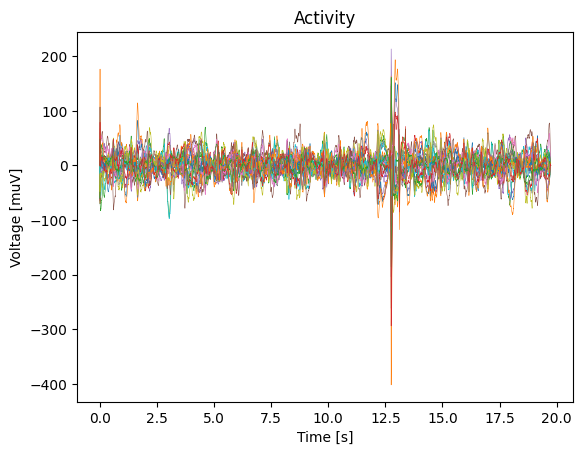

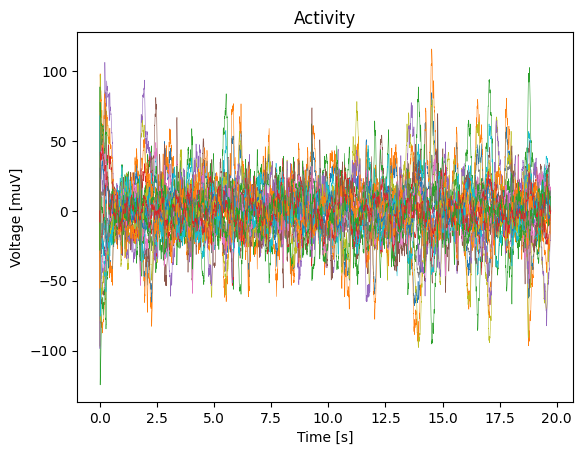

In [85]:
# Schaut euch an wie die Daten vorher aussehen
plot_signal(reconst_raw_active, electrodes=range(24))
plt.show()
plot_signal(reconst_raw_passive, electrodes=range(24))
plt.show()

### Topography

Als nächstes wollen wir sehen wie die gemessene Aktivität über die Elektroden (welche verschiedene Bereiche des Gehirns messen) verteilt ist. Da wir im obigen Schritt die Elektrodenposition bereits mit den Daten gelinkt haben, können wir die Aktivität nun für die ganze EEG Kappe grafisch darstellen.   

Dafür müssen wir uns erst einen Zeitpunkt aussuchen den wir betrachten wollen.

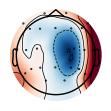

(<matplotlib.image.AxesImage at 0x22584d45ee0>,
 <matplotlib.contour.QuadContourSet at 0x22584df71c0>)

In [91]:
zeitpunkt = 3
viz.plot_topomap(np.array(reconst_raw_passive.get_data())[:, zeitpunkt*500], raw_passive_filtered.info)

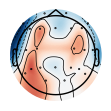

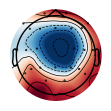

In [93]:
# wähle einen Zeitpunkt (in Sekunden)
zeitpunkt = 3
topography_data_active = np.array(reconst_raw_active.get_data())[:, zeitpunkt]
topography_data_passive = np.array(reconst_raw_passive.get_data())[:, zeitpunkt]

# Erstelle einen Topographie Plot
viz.plot_topomap(topography_data_active, raw_active.info)
viz.plot_topomap(topography_data_passive, raw_passive.info)
plt.show()

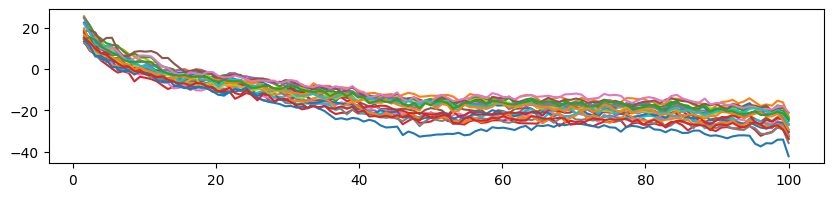

In [151]:
fig = plt.figure(figsize=(10,2))
plt.plot(freqs, 10 * np.log10(psds.T / (1e-6)**2))
plt.show()

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 10.240 (s)
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 10.240 (s)


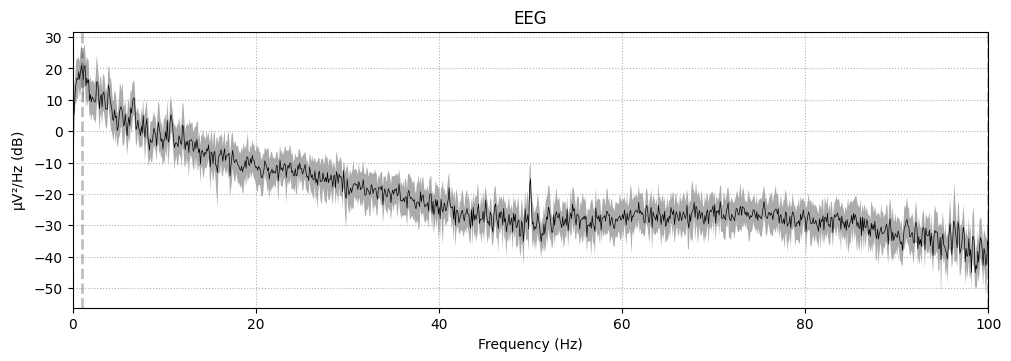

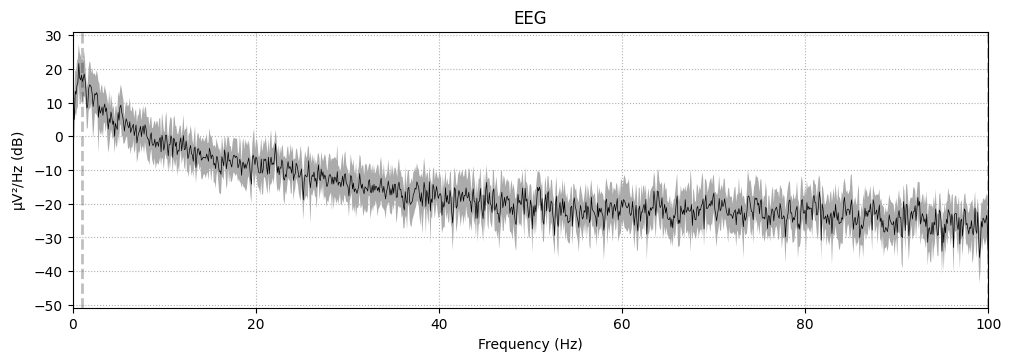

In [109]:
# Begutachte das Frequenzspektrum 
reconst_raw_active.plot_psd(show=False, average=True)
reconst_raw_passive.plot_psd(show=False, average=True)
plt.show()

In [123]:
np.min(reconst_raw_passive.compute_psd(average='mean').get_data().T)

Effective window size : 10.240 (s)


2.4389499837145346e-20

### Energieverbrauch berechnen
Da wir jetzt wissen wie viel power jede Frequenz hat, können wir die gesamte Power von allen Frequenzen berechnen. 

In [169]:
sfreq = reconst_raw_passive.info['sfreq']
psds_passive, freqs = mne.time_frequency.psd_array_welch(reconst_raw_passive.get_data(), sfreq=sfreq, fmin=1, fmax=100, average='mean')
psds_active, freqs = mne.time_frequency.psd_array_welch(reconst_raw_active.get_data(), sfreq=sfreq, fmin=1, fmax=100, average='mean')

# Umrechnen in bezibel (µV²/Hz)
db_psds_passive = 10 * np.log10(psds_passive / (1e-6)**2)
db_psds_active = 10 * np.log10(psds_active / (1e-6)**2)

energy_passive = np.sum(np.mean(db_psds_passive,0)**2)
energy_active =  np.sum(np.mean(db_psds_active,0)**2)
print("energy passive", energy_passive)
print("energy active", energy_active)

Effective window size : 1.280 (s)
Effective window size : 1.280 (s)
energy passive 37111.72207584663
energy active 56382.40794248162


Text(0.5, 1.0, 'Energy')

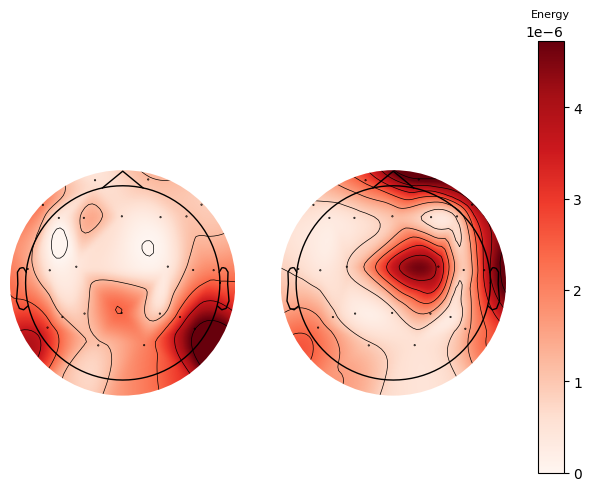

In [106]:
fig,(ax1,ax2) = plt.subplots(ncols=2)

im,cm = viz.plot_topomap(energy_active, reconst_raw_active.info, axes=ax1,show=False)
im,cm = viz.plot_topomap(energy_passive, reconst_raw_passive.info, axes=ax2, show=False)

# Position der colorbar
ax_x_start = 0.95
ax_x_width = 0.04
ax_y_start = 0.1
ax_y_height = 0.9

cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
clb = fig.colorbar(im, cax=cbar_ax)
clb.ax.set_title("Energy",fontsize=8) # title on top of colorbar

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 331 samples (1.655 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


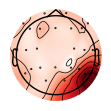

(<matplotlib.image.AxesImage at 0x22586256730>,
 <matplotlib.contour.QuadContourSet at 0x2258625f610>)

In [97]:
# Integriere das Power Spektrum beider Datensätze
active_aplha = reconst_raw_active.copy().filter(8,10)
integrated_active = np.sum(active_aplha.get_data()**2, 1)
viz.plot_topomap(integrated_active, active_aplha.info)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 331 samples (1.655 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


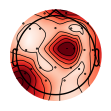

(<matplotlib.image.AxesImage at 0x2258781a490>,
 <matplotlib.contour.QuadContourSet at 0x2258781a6d0>)

In [96]:
# Integriere das Power Spektrum beider Datensätze
passive_aplha = reconst_raw_passive.copy().filter(8,10)
integrated_passive = np.sum(passive_aplha.get_data()**2, 1)
viz.plot_topomap(integrated_passive, passive_aplha.info)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 331 samples (1.655 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


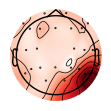

(<matplotlib.image.AxesImage at 0x22583ab7460>,
 <matplotlib.contour.QuadContourSet at 0x22583ab7700>)

In [107]:
reconst_active_aplha = reconst_raw_active.copy().filter(8,10)
integrated_active = np.sum(active_aplha.get_data()**2, 1)
viz.plot_topomap(integrated_active, reconst_active_aplha.info)

In [ ]:
integrated_passive